In [ ]:
!pip install matplotlib
!pip install pyglet==1.2.4

In [ ]:
import gym
import numpy as np

## outline & summary

- Q_learning => DQN
    - deep networks去逼近q functions
    - 返回action value
- policy network => Deep Policy Gradient
    - DPG 去逼近 $\pi_\theta(a_t|s_t)$ 
    - 输出概率分布，所以最后加一层softmax进行分类

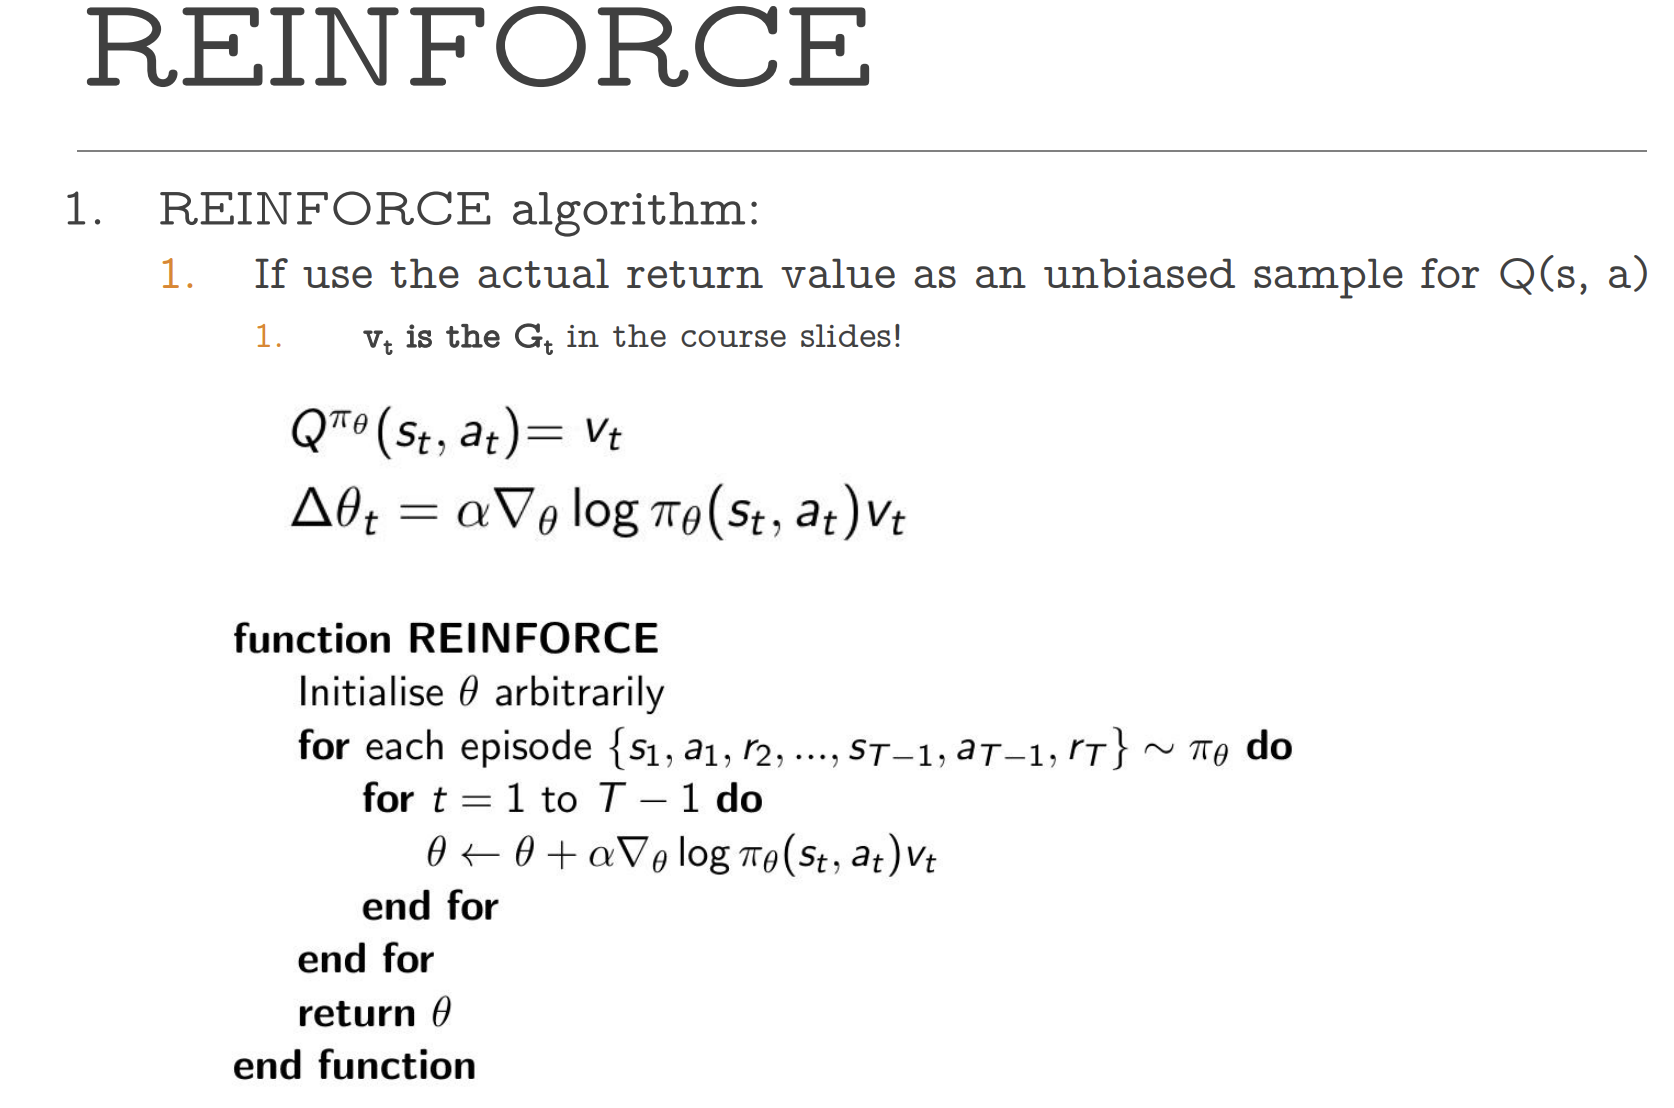

In [2]:
from IPython.core.display import Image
# http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf
Image('./image/reinforce.png')

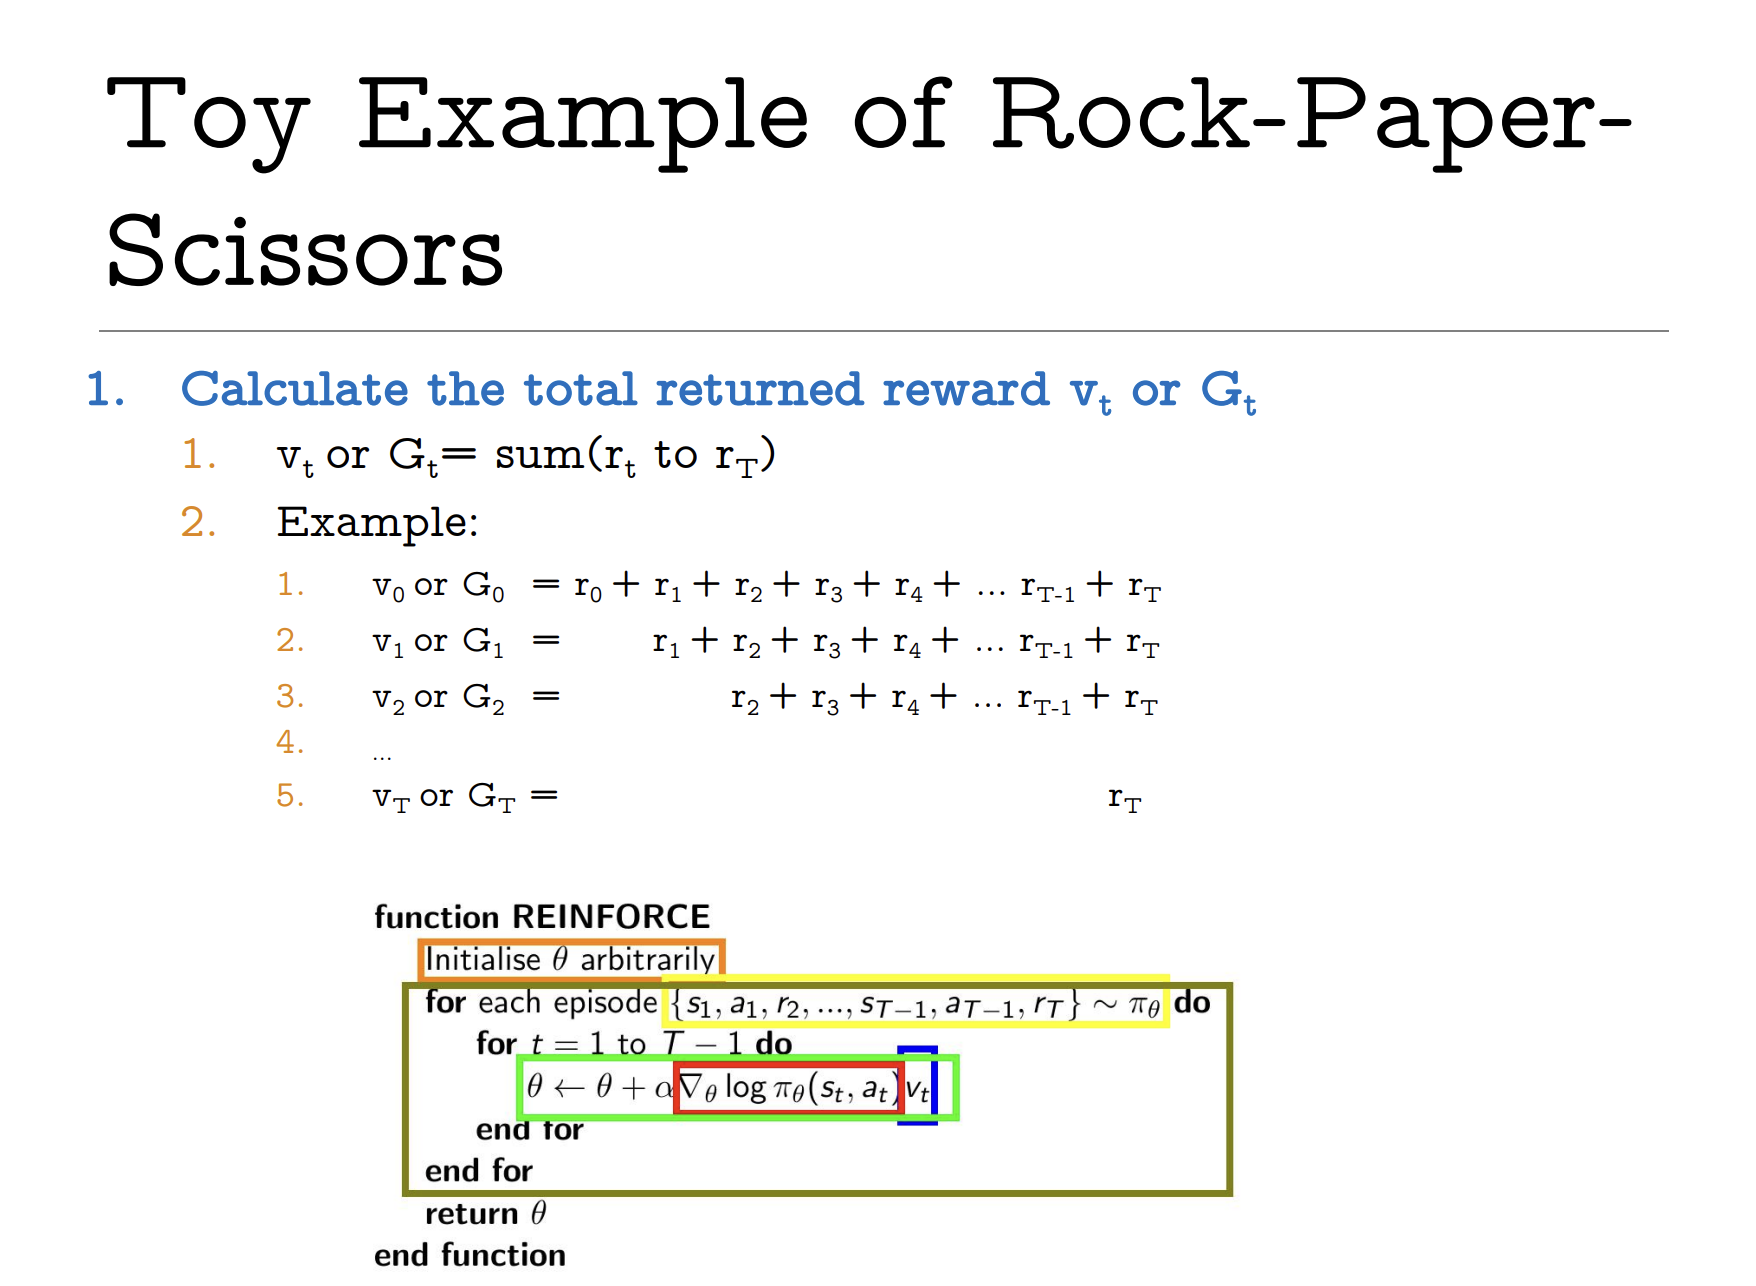

In [3]:
# http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf
# total discounted feature returned reward
Image('./image/reward.png')


- $ \sum_{t} \bigtriangledown_t \log(\pi_{\theta}(a_t|s_t))G_t $
- 注意，上述梯度更新的公式最大化总reward的期望，而神经网络是最小化一个目标，因此会加一个负号
- $ v_t = G_t = \sum_{k=0}^{\infty}\gamma^k R_{t+k+1} $
    - discounted future reward
    - 当前动作的reward通过基于当前状态的未来reward进行discounted estimate
- policy gradient
    - perform a trajectory roll-out using the current policy (fixed $\pi_\theta(s_t, a_t)$)
        - trajectory: $\tau=(s_1,a_1,r_2,s_2,a_2,r_3,...)$
        ```python
            s = env.reset()
            a, log_p = policy(s)
            next_state, reward, done, _ = env.step(a)
            if done:
                break
            s = next_state
        ```
        - store log probabilities $\pi_\theta(s_t, a_t)$ of policy and reward values at each step
            - 概率通过policy network获取
        - calculate discounted cumulative future reward at each step
        - compute policy gradient ($\bigtriangledown J(\theta)$) and update gradient parameter(gradient descent)
            - 反向传播，梯度更新有神经网络完成
            - $loss = -\sum_t \log(\pi_\theta(a_t|s_t))G_t$ 神经网络自动求导可以去掉 $\bigtriangledown$
            - `loss.backward()`

## 2.1 policy network

In [5]:
import torch
from torch import nn
from torch import optim
from torch import autograd
import torch.nn.functional as F
import numpy as np



In [7]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_states,num_actions,hidden_size,learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.fc1 = nn.Linear(num_states, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=1)
        return x
    

    def choose_action(self,state):
        # (4,) -> (1,4)
        state = torch.from_numpy(state).float().unsqueeze(0)
        # (1,2)
        probs = self.forward(autograd.Variable(state))
        # (1,2) -> (2,)
        # highest probability action
        action = np.random.choice(self.num_actions,p=np.squeeze(probs.detach().numpy()))
        # prob -> log prob
        log_prob = torch.log(probs.squeeze(0)[action])
        return action,log_prob


## 3. discounted future reward

In [8]:
GAMMA = 0.9

$ G_t = \sum_{t}^{\infty} \gamma^{k} R_{t+k+1} $

In [10]:
def discounted_future_reward(rewards):
    discounted_future_reward = []
    for t in range(len(rewards)):
        Gt=k=0
        for r in rewards[t:]:
            Gt+=(GAMMA**k)*r # r= $R_{t+k+1}$
            k+=1
        discounted_future_reward.append(Gt)
    return discounted_future_reward

## 4. update policy

In [11]:
def update_policy(policy_network, rewards, log_probs):
    # G_t
    discounted_rewards = discounted_future_reward(rewards)
    # normalize discounted rewards => stability
    # from one episode
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (
        discounted_rewards-discounted_rewards.mean())/(discounted_rewards.std()+1e-9)
    policy_grads = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_grads.append(-log_prob*Gt)
    policy_network.optimizer.zero_grad()
    loss = torch.stack(policy_grads).sum()
    loss.backward()
    policy_network.optimizer.step()

In [ ]:
## 4. 创建环境

In [14]:
import gym
env = gym.make('CartPole-v0')
env.observation_space,env.action_space

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

episode: 0, total reward: 13.0, average_reward: 13.0, length: 12
episode: 100, total reward: 22.0, average_reward: 23.465346534653467, length: 21
episode: 200, total reward: 38.0, average_reward: 26.26865671641791, length: 37
episode: 300, total reward: 18.0, average_reward: 29.54485049833887, length: 17
episode: 400, total reward: 30.0, average_reward: 32.37655860349127, length: 29
episode: 500, total reward: 41.0, average_reward: 36.55289421157685, length: 40
episode: 600, total reward: 38.0, average_reward: 41.848585690515804, length: 37
episode: 700, total reward: 158.0, average_reward: 49.9885877318117, length: 157
episode: 800, total reward: 35.0, average_reward: 62.09612983770287, length: 34
episode: 900, total reward: 182.0, average_reward: 74.38111111111111, length: 181
episode: 1000, total reward: 251.0, average_reward: 88.36836836836837, length: 250
episode: 1100, total reward: 292.0, average_reward: 98.99726277372262, length: 291
episode: 1200, total reward: 242.0, average_

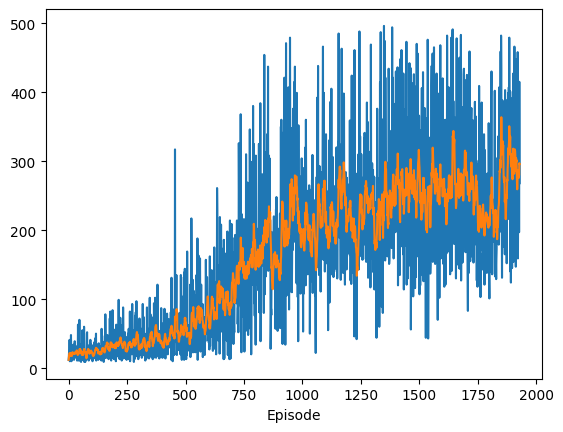

In [16]:
policy_network = PolicyNetwork(
    env.observation_space.shape[0], env.action_space.n, 128)
max_episode_num = 2000
max_steps = 500

num_steps = []
avg_num_steps = []
all_rewards = []

for episode in range(max_episode_num):
    state, _ = env.reset()
    log_probs = []
    rewards = []
    for step in range(max_steps):
        action, log_prob = policy_network.choose_action(state)
        next_state, reward, done, _, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_network, rewards, log_probs)
            num_steps.append(step)
            avg_num_steps.append(np.mean(num_steps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 100 == 0:
                print(f'episode: {episode}, total reward: {sum(rewards)}, average_reward: {np.mean(all_rewards)}, length: {step}')
            break
        
        state = next_state

from matplotlib import pyplot as plt
plt.plot(num_steps)
plt.plot(avg_num_steps)
plt.xlabel('Episode')
plt.show()

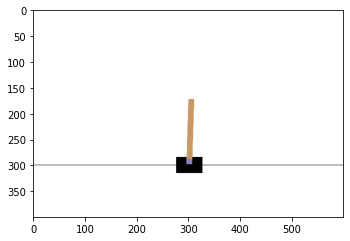

: 

In [72]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


# def display_frames_to_video(frames, name):
plt.figure(figsize=(frames[0].shape[0]/72, frames[0].shape[1]/72), dpi=72)
patch = plt.imshow(frames[0])

def animate(i):
    patch.set_data(frames[i])
anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=range(len(frames)), interval=50)
anim.save(f"xx.gif")
# HTML(anim.to_jshtml())

# display_frames_to_video(frames=frames, name="xx")